In [1]:
import qmps
import xmps
import cirq
from xmps import iMPS
import numpy as np
def ap(A, _abs = True):
    if _abs:
        print(np.around(np.abs(A), 2))
    else:
        print(np.around(A, 2))

In [5]:
from numpy.linalg import svd

def S(ρ):
    # S = Σᵢρᵢlog(ρᵢ) where ρᵢ = |λᵢ|^2 and λᵢ = singular values 
    u, s, v = svd(ρ) 
    s = np.square(np.abs(s)) 
    return np.dot(np.log2(s), s)
    

### Finding Parameterization of the 2 parameter scar mps

In [5]:
A = lambda ϕ, θ: np.array([[[0, 1j*np.exp(-1j*ϕ)], 
                            [0,0]],
                          [[np.cos(θ), 0],
                           [np.sin(θ), 0]]])

U = lambda θ, ϕ: np.array([
    [0,1j*np.exp(-1j*ϕ),0,0],
    [np.cos(θ), 0, 0, -np.sin(θ)],
    [0,0,1,0],
    [np.sin(θ), 0, 0, np.cos(θ)]
])

for x,y in zip(np.random.randn(10), np.random.randn(10)):
    assert np.allclose(U(x,y).conj().T@U(x,y), np.eye(4))

#### Exact Hamiltonian for simulation

In [34]:
import numpy as np
from numpy import kron
from functools import reduce
from scipy.linalg import expm
from qmps.represent import Tensor
def multi_tensor(Ops):
    return reduce(kron, Ops)

### Exact hamiltonian simulation for prof of principle ###
P = np.array([[0,0],[0,1]])
X = np.array([[0,1],[1,0]])
n = np.array([[1,0],[0,0]])
I = np.eye(2)

H = lambda μ:0.5*(multi_tensor([I,P,X,P]) + multi_tensor([P,X,P,I])) + (μ/4) * (multi_tensor([I,I,I,n]) + 
                                                                                multi_tensor([I,I,n,I]) +
                                                                                multi_tensor([I,n,I,I]) + 
                                                                                multi_tensor([n,I,I,I]))

W = lambda μ, dt: Tensor(expm(1j * dt * H(μ)),'H')

In [6]:
from qmps.time_evolve_tools import merge

# bUILDING THE TWO SITES FROM As

def two_site_As(θ, ϕ, θ_, ϕ_):
    A1 = A(ϕ, θ)
    A2 = A(ϕ_, θ_)
    return merge(A1,A2)

def generate_two_site_unitary(params):
    return tensor_to_unitary(two_site_As(*params))

##### Using the Direct Parametrization to build the 2-site unitary:

In [67]:
class ScarGate(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ, θ', ϕ']
        
    def num_qubits(self):
        return 3
    
    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ, θ_, ϕ_ = self.params
        return [
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ_ + (π/2))).on(q[2]),
            cirq.X.on(q[1]),
            cirq.CNOT(q[1], q[2]),
            cirq.X.on(q[1]),
            cirq.CNotPowGate(exponent=2*θ_/π).on(q[2], q[1]),
            cirq.S.on(q[1]),
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ + (π/2))).on(q[1]),
            cirq.X.on(q[0]),
            cirq.CNOT(q[0], q[1]),
            cirq.X.on(q[0]),
            cirq.CNotPowGate(exponent=2*θ/π).on(q[1], q[0]),
            cirq.S.on(q[0])
        ]
    
u_scar = ScarGate([1,2,3,4])

q = cirq.LineQubit.range(3)
c = cirq.Circuit.from_ops([cirq.decompose_once(u_scar.on(*q))])
print(c)
        

0: ───X───────────────────────────────────────────@───X───X──────────S───
                                                  │       │
1: ───X─────────@───X───X───────────S───Z^0.137───X───────@^(7/11)───────
                │       │
2: ───Z^0.773───X───────@^(-1/11)────────────────────────────────────────


##### Trying to get the environment exactly

In [72]:
import sympy as sp
from sympy import symbols,init_printing, I
init_printing(use_latex='mathjax')

θ1, ϕ1, θ2, ϕ2 = symbols('theta_1 phi_1 theta_2 phi_2', real = True)
θ1, ϕ2

A_sp = lambda θ, ϕ: sp.Array([[[0, I*sp.exp(-I*ϕ)], 
                               [0,0]],
                               [[sp.cos(θ), 0],
                               [sp.sin(θ), 0]]])




A1 = A_sp(θ1, ϕ1)
A2 = A_sp(θ2, ϕ2)

from sympy import tensorproduct, tensorcontraction, permutedims

def merge_sp(A1, A2):
    # Merge two Bond Dim 2 Matrix Product States using Sympy
    contracted = tensorcontraction(tensorproduct(A1,A2),(2,4))
    permuted = permutedims(contracted, (0,2,1,3))
    return permuted.reshape(4,2,2)

A12 = merge_sp(A1,A2)
A12 [2,:,:] 

def transfer_matrix_sp(A12):
    # contract two 'merged' objects on their physical index, and group the remaining indices so it is a 4x4 matrix
    flipped = permutedims(A12, (0,1,2))
    flipped = flipped.conjugate()
    contracted = tensorcontraction(tensorproduct(A12, flipped),(0,3))
    grouped = permutedims(contracted,(0,2,1,3))
    return grouped.reshape(4,4).tomatrix()

tm = transfer_matrix_sp(A12)

result = tm.eigenvects()
environment = result[1][2][0].reshape(2,2)
environment

⎡                                        2                                    
⎢                                    -cos (θ₁)                                
⎢                         ────────────────────────────────                    
⎢                            2          2        2                            
⎢                         sin (θ₂) + cos (θ₁)⋅cos (θ₂) - 1                    
⎢                                                                             
⎢ ⎛⎛   2          2        2        ⎞                              3        2 
⎢-⎝⎝sin (θ₂) + cos (θ₁)⋅cos (θ₂) - 1⎠⋅sin(θ₁)⋅cos(θ₁) - sin(θ₁)⋅cos (θ₁)⋅cos (
⎢─────────────────────────────────────────────────────────────────────────────
⎢                             2          2        2                           
⎣                        - sin (θ₂) - cos (θ₁)⋅cos (θ₂) + 1                   

        ⎛⎛   2          2        2        ⎞                              3    
       -⎝⎝sin (θ₂) + cos (θ₁)⋅cos (θ₂) - 1⎠⋅sin(θ₁)

The analytical expression is not that useful since it appears too complicated to easily express with rotation gates

##### Making the Hamiltonian:

In [99]:
# How to build custom controlled gates:
# - IMPORTANT: LATER VERSIONS OF CIRQ HAVE CHANGED CONTROLLED GATE AND THIS WILL HAVE TO BE CHANGE IF WE UPDATE

q = cirq.LineQubit.range(3)
c = cirq.Circuit.from_ops(
    cirq.ControlledGate(
        sub_gate=cirq.XPowGate(),
        num_controls = 2, 
        control_qubits=[q[0], q[2]]).on(q[1])   
)


In [4]:
class PXPHamiltonian(cirq.Gate):
    def __init__(self, dt):
        self.dt = dt
    
    def num_qubits(self):
        return 4
    
    def _decompose_(self, qubits):
        q = qubits
        return[
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[0], q[2]]).on(q[1]),
            
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3]),

            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[1], q[3]]).on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3])

        ]
    
    def _circuit_diagram_info_(self, args):
        return ['H']*self.num_qubits()

    




0: ───X───@─────────X─────────────────
          │
1: ───────X─────────X───@─────────X───
          │             │
2: ───X───@^0.032───X───X─────────────
                        │
3: ───X─────────────────@^0.032───X───


In [18]:
from xmps.iMPS import Map
from qmps.time_evolve_tools import put_env_on_right_site, put_env_on_left_site
from qmps.represent import Environment 

class ScarGate(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ, θ', ϕ']

    def num_qubits(self):
        return 3

    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ, θ_, ϕ_ = self.params
        return [
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ_ + (π/2))).on(q[2]),
            cirq.X.on(q[1]),
            cirq.CNOT(q[1], q[2]),
            cirq.X.on(q[1]),
            cirq.CNotPowGate(exponent=2*θ_/π).on(q[2], q[1]),
            cirq.S.on(q[1]),
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ + (π/2))).on(q[1]),
            cirq.X.on(q[0]),
            cirq.CNOT(q[0], q[1]),
            cirq.X.on(q[0]),
            cirq.CNotPowGate(exponent=2*θ/π).on(q[1], q[0]),
            cirq.S.on(q[0])
        ]
    
    def _circuit_diagram_info_(self, args):
        return ['U']*self.num_qubits()

A = lambda θ, ϕ: np.array([[[0, 1j*np.exp(-1j*ϕ)], 
                            [0,0]],
                           [[np.cos(θ), 0],
                            [np.sin(θ), 0]]])


ham = PXPHamiltonian(0.1)

def scars_time_evolve_cost_function(params, current_params, ham):
    '''
    params are formatted like: [θ1, ϕ1, θ2, ϕ2]
    '''    
    θ1, ϕ1, θ2, ϕ2 = current_params
    θ1_,ϕ1_,θ2_, ϕ2_ = params

    A1 = A(θ1, ϕ1)
    A2 = A(θ2, ϕ2)
    A1_= A(θ1_, ϕ1_)
    A2_= A(θ2_, ϕ2_)
    
    _, r = Map(merge(A1,A2), merge(A1_,A2_)).right_fixed_point()
    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(r.conj().T),'L')
    
    U12 = ScarGate(current_params)
    U12_= ScarGate(params)
    q = cirq.LineQubit.range(8)
    circuit = cirq.Circuit.from_ops([
        cirq.H(q[5]),
        cirq.CNOT(q[5],q[6]),
        U12(*q[3:6]),
        U12(*q[1:4]),
        L(*q[0:2]),
        ham(*q[2:6]),
        R(*q[6:8]),
        cirq.inverse(U12_(*q[1:4])),
        cirq.inverse(U12_(*q[3:6])),
        cirq.CNOT(q[5],q[6]),
        cirq.H(q[5])
    ])
    
    # print(circuit.to_text_diagram(transpose = True))
    sim = cirq.Simulator()
    ψ = sim.simulate(circuit).final_state[0]
    return -np.abs(ψ)*2

scars_time_evolve_cost_function(current_params, current_params, hamiltonian)

-0.9999904036521912

In [22]:
from scipy.optimize import minimize
from tqdm.notebook import tqdm
timesteps = 2000
hamiltonian = PXPHamiltonian(0.01)
current_params = [0,np.random.randn(1)[0], np.pi/2, np.random.randn(1)[0]]
final_params = []

for _ in tqdm(range(timesteps)):
    final_params.append(current_params)
    initial_params = current_params
    res = minimize(scars_time_evolve_cost_function, initial_params, args = (current_params, hamiltonian), options = {'disp':True}, method = 'Nelder-Mead')
    current_params = res.x

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 90
Optimization terminated s

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 27
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 27
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 98
Optimization terminated s

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 113
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 48
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 23
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 29
         Function evaluations: 92
Optimization terminated

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 44
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 30
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 23
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 101
Optimization terminated 

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 112
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 30
         Function evaluations: 99
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 97
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 27
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 123
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 30
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 97
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 113
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 44
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 44
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 109
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 46
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 115
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 140
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 53
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 51
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 148
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 47
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 51
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 148
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 59
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 55
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 55
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 58
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 172
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 48
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 51
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 60
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 55
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 163
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 60
         Function evaluations: 171
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 59
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 61
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 61
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 171
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 60
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 66
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 69
         Function evaluations: 205
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 53
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 189
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 212
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 58
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 59
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 61
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 191
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 66
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 76
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 69
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 203
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 67
         Function evaluations: 203
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 67
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 74
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 74
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 218
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 69
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 76
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 80
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 71
         Function evaluations: 234
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 81
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 240
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 72
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 76
         Function evaluations: 240
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 245
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 89
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 80
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 86
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 85
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 86
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 256
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 87
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 251
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 82
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 92
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 88
         Function evaluations: 262
Optimization termina

## Putting it all together:

In [ ]:
#### Use this for a shallow representation of the PXP, 
#### otherwise use the W lambda function which is exact but might be really deep on chip ###

class PXPHamiltonian(cirq.Gate):
    def __init__(self, dt):
        self.dt = dt
    
    def num_qubits(self):
        return 4
    
    def _decompose_(self, qubits):
        q = qubits
        return[
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[0], q[2]]).on(q[1]),
            
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3]),

            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[1], q[3]]).on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3])

        ]
    
    def _circuit_diagram_info_(self, args):
        return ['H']*self.num_qubits()


In [71]:
import numpy as np
from numpy import kron
from functools import reduce
from scipy.linalg import expm
from qmps.states import Tensor
from qmps.tools import tensor_to_unitary
import cirq
from qmps.time_evolve_tools import merge, put_env_on_left_site, put_env_on_right_site
from xmps.iMPS import Map
from scipy.optimize import minimize
from tqdm.notebook import tqdm 
import tqdm as tq
from numba import jit
import matplotlib.pyplot as plt
from joblib import Parallel, delayed 

def multi_tensor(Ops):
    return reduce(kron, Ops)

### Exact hamiltonian simulation for prof of principle ###
P = np.array([[0,0],[0,1]])
X = np.array([[0,1],[1,0]])
n = np.array([[1,0],[0,0]])
I = np.eye(2)

H = lambda μ:0.5*(multi_tensor([I,P,X,P]) + multi_tensor([P,X,P,I])) + (μ/4) * (multi_tensor([I,I,I,n]) + 
                                                                                multi_tensor([I,I,n,I]) +
                                                                                multi_tensor([I,n,I,I]) + 
                                                                                multi_tensor([n,I,I,I]))

W = lambda μ, dt: Tensor(expm(1j * dt * H(μ)),'H')

class ScarsAnsatz(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ]
        
    def num_qubits(self):
        return 2
    
    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ = self.params
        return [
            cirq.ZPowGate(exponent=1/2 - ϕ/π).on(q[1]),
            cirq.X.on(q[0]),
            cirq.CNOT(q[0], q[1]),
            cirq.X.on(q[0]),
            cirq.CNotPowGate(exponent=2*θ/π).on(q[1], q[0]),  # global_shift is needed to remove erronous complex numbers
            cirq.S.on(q[0]),
            cirq.ZPowGate(exponent=-θ/π).on(q[1])
        ]

class ScarGate(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ, ϕ', θ']

    def num_qubits(self):
        return 3

    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ, ϕ_, θ_ = self.params
        return [
            ScarsAnsatz([θ_, ϕ_]).on(*q[1:3]),
            ScarsAnsatz([θ, ϕ]).on(*q[0:2])
        ]
    
    def _circuit_diagram_info_(self, args):
        return ['U']*self.num_qubits()

A = lambda θ, ϕ: np.array([[[0, 1j*np.exp(-1j*ϕ)], 
                            [0,0]],
                           [[np.cos(θ), 0],
                            [np.sin(θ), 0]]])

def scars_time_evolve_cost_function(params, current_params, ham):
    '''
    params are formatted like: [θ1, ϕ1, ϕ2, θ2], for convenience with the classical differential eqn solver
    '''    
    #θ1, ϕ1, ϕ2, θ2 = current_params
    #θ1_, ϕ1_, ϕ2_, θ2_ = params
    θ1, θ2 = current_params
    θ1_, θ2_ = params
    
    current_params = [θ1, 0, 0, θ2]
    params = [θ1_, 0, 0, θ2_]
    
    A1 = A(θ1, 0)    # A(θ1, ϕ1)
    A2 = A(θ2, 0)    # A(θ2, ϕ2)
    A1_= A(θ1_, 0)   # A(θ1_, ϕ1_)
    A2_= A(θ2_, 0) # A(θ2_, ϕ2_)
    
    _, r = Map(merge(A1,A2), merge(A1_,A2_)).right_fixed_point()
    R = Tensor(put_env_on_left_site(r), 'R')
    L = Tensor(put_env_on_right_site(r.conj().T),'L')
    
    U12 = ScarGate(current_params)
    U12_= ScarGate(params)
    q = cirq.LineQubit.range(8)
    circuit = cirq.Circuit.from_ops([
        cirq.H(q[5]),
        cirq.CNOT(q[5],q[6]),
        U12(*q[3:6]),
        U12(*q[1:4]),
        L(*q[0:2]),
        ham(*q[2:6]),
        R(*q[6:8]),
        cirq.inverse(U12_(*q[1:4])),
        cirq.inverse(U12_(*q[3:6])),
        cirq.CNOT(q[5],q[6]),
        cirq.H(q[5])
    ])
    
    # print(circuit.to_text_diagram(transpose = True))
    sim = cirq.Simulator()
    ψ = sim.simulate(circuit).final_state[0]
    return -np.abs(ψ)*2

def scars_cost_fun_alternate(params, current_params, ham):
    '''
    This cost function doesn't use the quantum circuit parameterisation
    
    params are formatted like: [θ1, ϕ1, ϕ2, θ2], for convenience with the classical differential eqn solver
    '''    
    θ1, ϕ1, ϕ2, θ2 = current_params
    θ1_, ϕ1_, ϕ2_, θ2_ = params

    A1 = A(θ1, ϕ1)
    A2 = A(θ2, ϕ2)
    A1_= A(θ1_, ϕ1_)
    A2_= A(θ2_, ϕ2_)
    
    A12 = merge(A1,A2)
    A12_= merge(A1_,A2_)
    
    _, r = Map(A12, A12_).right_fixed_point()
    R = Tensor(put_env_on_left_site(r), 'R')
    L = Tensor(put_env_on_right_site(r.conj().T),'L')
    
    U12 = Tensor(tensor_to_unitary(A12),'U')
    U12_= Tensor(tensor_to_unitary(A12_),'U\'')
    
    q = cirq.LineQubit.range(8)
    circuit = cirq.Circuit.from_ops([
        cirq.H(q[5]),
        cirq.CNOT(q[5],q[6]),
        U12(*q[3:6]),
        U12(*q[1:4]),
        L(*q[0:2]),
        ham(*q[2:6]),
        R(*q[6:8]),
        cirq.inverse(U12_(*q[1:4])),
        cirq.inverse(U12_(*q[3:6])),
        cirq.CNOT(q[5],q[6]),
        cirq.H(q[5])
    ])
    
    # print(circuit.to_text_diagram(transpose = True))
    sim = cirq.Simulator()
    ψ = sim.simulate(circuit).final_state[0]
    return -np.abs(ψ)*2

def simulate_scars(initial_params, params):
    dt, timesteps = params
    μ = 0.325
    hamiltonian = W(μ, dt)
    final_params = []
    current_params = initial_params
    for _ in range(timesteps):
        final_params.append(np.mod(current_params, 2*np.pi))
        res = minimize(scars_time_evolve_cost_function, current_params, args = (current_params, hamiltonian), options = {'disp':True}, method = 'Nelder-Mead')
        current_params = res.x
    
#     if save_file:
#         np.save(save_file, np.array(final_params))
    
    return np.array(final_params)

t = np.arange(0,50,0.01)
dt = 0.3
steps = 500

N = 15

ϕ1_line = np.linspace(0,np.pi * 2, N)
θ2_line = np.linspace(0, 2*np.pi, N)
x,y = np.meshgrid(θ1_line, θ1_line)
list_of_values = []
for i in range(len(x)):
    for j in range(len(y)):
        list_of_values.append([x[i,j], y[i,j]])

parameters = [dt, steps] 

list_of_angles = Parallel(n_jobs=-1)(delayed(simulate_scars)(i, parameters) for i in tq.tqdm(list_of_values))

import pickle
with open(f'parallel_quantum_figure_{15**2}', 'wb') as fp:
    pickle.dump(list_of_angles, fp)


# for i in tq.tqdm(range(N)):
#     for j in range(N):
#         θ1s = []
#         θ2s = [] b 

#         θ1 = (i+1) * 2 * np.pi / N
#         θ2 = (j+1) * 2 * np.pi / N
#         res = simulate_scars(dt, steps, 0, [θ1, θ2])
            
#         plt.scatter(res[:,0], res[:,-1], s = 0.1)
# plt.show()


100%|██████████| 225/225 [1:48:22<00:00, 28.90s/it]


225


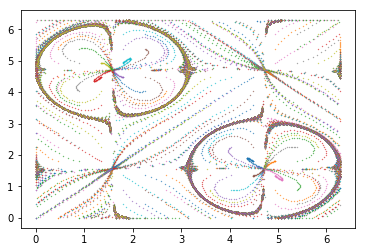

In [72]:
print(len(list_of_angles))
for init_cond in list_of_angles:
    plt.scatter(init_cond[:,0], init_cond[:,1], s=0.1)

#### ODE Analytical Solver:

##### Fixing to a specific energy surface:

<IPython.core.display.Javascript object>


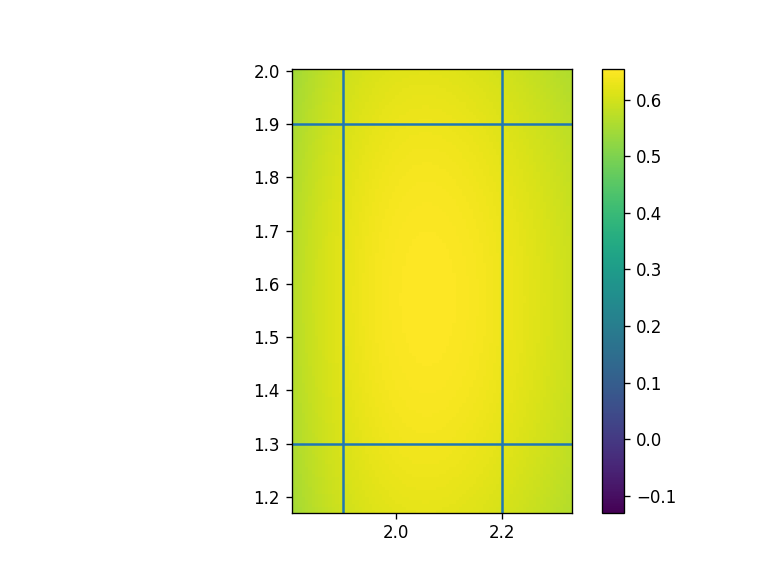

In [27]:
# Here is the surfaces of constant energy:
from tqdm.notebook import tqdm 
import tqdm as tq
from numpy import sin, cos, tan, arcsin, pi
import numpy as np
from scipy.integrate import odeint
from joblib import Parallel, delayed
from multiprocessing import cpu_count


dθdt = lambda θ1, ϕ1, ϕ2, θ2: tan(θ2)*sin(θ1)*(cos(θ1)**2)*cos(ϕ1) + cos(θ2)*cos(ϕ2)
dϕdt = lambda θ1, ϕ1, ϕ2, θ2: 2*tan(θ1)*cos(θ2)*sin(ϕ2) - 0.5*tan(θ2)*cos(θ1)*sin(ϕ1)*(2*(sin(θ2)**-2) + cos(2*θ1) -5) 

H_denom = lambda θ1, θ2: cos(θ1)**2 + (cos(θ2)*sin(θ1))**2
H1 = lambda θ1, ϕ1, θ2: 1/(H_denom(θ1, θ2)) * (sin(2*θ2) * sin(ϕ1) * cos(θ1)**3) 
H2 = lambda θ1, ϕ2, θ2: 1/(H_denom(θ1, θ2)) * (sin(2*θ1) * sin(ϕ2) * cos(θ2)**3) 
H3 = lambda θ1, θ2, μ: (1/(2*H_denom(θ1, θ2))) * μ * (1 - cos(2*θ1)*cos(2*θ2))

H = lambda θ1, ϕ1, ϕ2, θ2, μ: H1(θ1, ϕ1, θ2) + H2(θ1, ϕ2, θ2) + H3(θ1, θ2, μ)

def func_list(angles,t,μ):
    return[dθdt(*angles), -μ + dϕdt(*angles), -μ + dϕdt(*reversed(angles)), dθdt(*reversed(angles))]

# set θ1 = 0.9 and ϕ2 = 0

def H_ef(θ2, ϕ1): # energy_fixed
    return H(0.9,ϕ1,0,θ2,0.325)

θ2_l = np.linspace(0,2*np.pi, 1000)
ϕ1_l = np.linspace(0,2*np.pi, 1000)
x,y = np.meshgrid(ϕ1_l, θ2_l)

H_ef(x,y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

im = ax.imshow(H_ef(x,y), extent = [0, 2*np.pi, 0, 2*np.pi])
ax.axhline(1.3)
ax.axhline(1.9)
ax.axvline(1.9)
ax.axvline(2.2)
fig.colorbar(im)
plt.show()

# we have identified an area of roughly equal energy, lets try evolving a state with these
# initial conditions, 1.3<θ2<1.9 and 1.9<ϕ1<2.2

In [9]:
from tqdm.notebook import tqdm 
import tqdm as tq
from numpy import sin, cos, tan, arcsin, pi
import numpy as np
from scipy.integrate import odeint
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from scipy.integrate import odeint, solve_ivp

dθdt = lambda θ1, ϕ1, ϕ2, θ2: tan(θ2)*sin(θ1)*(cos(θ1)**2)*cos(ϕ1) + cos(θ2)*cos(ϕ2)
dϕdt = lambda θ1, ϕ1, ϕ2, θ2: 2*tan(θ1)*cos(θ2)*sin(ϕ2) - 0.5*tan(θ2)*cos(θ1)*sin(ϕ1)*(2*(sin(θ2)**-2) + cos(2*θ1) -5) 

H_denom = lambda θ1, θ2: cos(θ1)**2 + (cos(θ2)*sin(θ1))**2
H1 = lambda θ1, ϕ1, θ2: 1/(H_denom(θ1, θ2)) * (sin(2*θ2) * sin(ϕ1) * cos(θ1)**3) 
H2 = lambda θ1, ϕ2, θ2: 1/(H_denom(θ1, θ2)) * (sin(2*θ1) * sin(ϕ2) * cos(θ2)**3) 
H3 = lambda θ1, θ2, μ: (1/(2*H_denom(θ1, θ2))) * μ * (1 - cos(2*θ1)*cos(2*θ2))

H = lambda θ1, ϕ1, ϕ2, θ2, μ: H1(θ1, ϕ1, θ2) + H2(θ1, ϕ2, θ2) + H3(θ1, θ2, μ)


def ode_solver(init_angles, t_eval = None):
    
    def func_list(t, angles):
        return[dθdt(*angles), -0.325 + dϕdt(*angles), -0.325 + dϕdt(*reversed(angles)), dθdt(*reversed(angles))]
    
    y0 = init_angles
    #final = (t_eval[1] - t_eval[0]) * (len(t_eval) + 1)
    
    return solve_ivp(func_list,(0,1000), y0, method = "Radau", t_eval= t_eval)

def findϕ2(ϕ1, θ2):
    θ1 = 0.9
    μ = 0.325
    find_sin = lambda θ1, ϕ1, θ2, μ: ((μ/2) * (cos(2*θ1)*cos(2*θ2) -1) - (sin(2*θ2)*sin(ϕ1)*cos(θ1)**3)) / (sin(2*θ1)*cos(θ2)**3)
    sinϕ = find_sin(θ1, ϕ1, θ2, μ)
    return sinϕ

find_sin = lambda θ1, ϕ1, θ2, μ: ((μ/2) * (cos(2*θ1)*cos(2*θ2) -1) - (sin(2*θ2)*sin(ϕ1)*cos(θ1)**3)) / (sin(2*θ1)*cos(θ2)**3)
θ2_line = np.arange(0.01, 2*np.pi, 0.3)
ϕ1_line = np.arange(0.01, 2*np.pi, 0.3)
x,y = np.meshgrid(ϕ1_line, θ2_line)
list_of_values = []
for i in range(len(x)):
    for j in range(len(y)):
        ϕ1 = x[i,j]
        θ2 = y[i,j]
        sinϕ2 = find_sin(0.9, ϕ1, θ2, 0.325)
        if sinϕ2 < -1 or sinϕ2 > 1:
            continue
        else:
            list_of_values.append([0.9, ϕ1, arcsin(sinϕ2), θ2])

print(len(list_of_values))
#t = [i*0.025 for i in range(1,2000)]
list_of_angles = Parallel(n_jobs=-1)(delayed(ode_solver)(i) for i in tq.tqdm(list_of_values))




  0%|          | 0/285 [00:00<?, ?it/s]

285




 11%|█         | 32/285 [00:26<00:42,  5.91it/s]

  6%|▌         | 16/285 [00:14<00:04, 62.32it/s]

 11%|█         | 32/285 [00:37<02:59,  1.41it/s]

 17%|█▋        | 48/285 [01:00<03:39,  1.08it/s]

 22%|██▏       | 64/285 [01:17<03:32,  1.04it/s]

 28%|██▊       | 80/285 [01:26<02:54,  1.17it/s]

 34%|███▎      | 96/285 [01:36<02:27,  1.28it/s]

 39%|███▉      | 112/285 [01:48<02:13,  1.30it/s]

 45%|████▍     | 128/285 [01:58<01:54,  1.38it/s]

 51%|█████     | 144/285 [02:13<01:51,  1.26it/s]

 56%|█████▌    | 160/285 [02:26<01:39,  1.25it/s]

 62%|██████▏   | 176/285 [02:52<01:53,  1.04s/it]

 67%|██████▋   | 192/285 [03:15<01:48,  1.17s/it]

 73%|███████▎  | 208/285 [03:32<01:26,  1.13s/it]

 79%|███████▊  | 224/285 [03:45<01:03,  1.04s/it]

 84%|████████▍ | 240/285 [03:55<00:41,  1.09it/s]

 90%|████████▉ | 256/285 [04:04<00:23,  1.25it/s]

100%|██████████| 285/285 [04:17<00:00,  1.11it/s]


In [ ]:
find_sin = lambda theta1, phi1, theta2, mu: ((mu/2) * (cos(2*theta1)*cos(2*theta2) -1) - (sin(2*theta2)*sin(phi1)*cos(theta1)**3)) / (sin(2*theta1)*cos(theta2)**3)


<IPython.core.display.Javascript object>


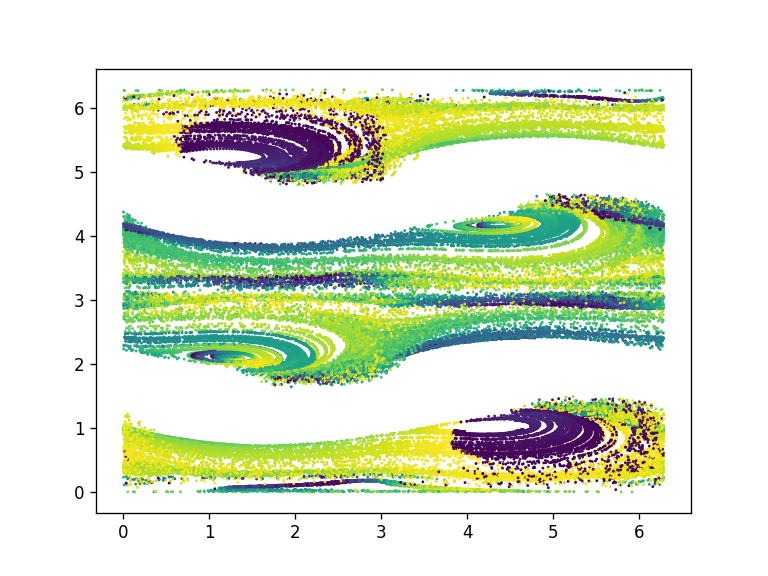



  0%|          | 0/285 [00:00<?, ?it/s]

  0%|          | 1/285 [00:00<02:26,  1.93it/s]

  1%|          | 2/285 [00:00<02:20,  2.02it/s]

  1%|          | 3/285 [00:01<02:21,  1.99it/s]

  1%|▏         | 4/285 [00:02<02:23,  1.96it/s]

  2%|▏         | 5/285 [00:02<02:01,  2.30it/s]

  2%|▏         | 6/285 [00:02<01:50,  2.53it/s]

  2%|▏         | 7/285 [00:02<01:51,  2.49it/s]

  3%|▎         | 8/285 [00:03<01:52,  2.46it/s]

  3%|▎         | 9/285 [00:03<01:52,  2.45it/s]

  4%|▎         | 10/285 [00:04<01:54,  2.40it/s]

  4%|▍         | 11/285 [00:04<01:53,  2.42it/s]

  4%|▍         | 12/285 [00:04<01:38,  2.76it/s]

  5%|▍         | 13/285 [00:05<01:44,  2.59it/s]

  5%|▍         | 14/285 [00:05<01:48,  2.49it/s]

  5%|▌         | 15/285 [00:06<01:55,  2.34it/s]

  6%|▌         | 16/285 [00:06<02:02,  2.19it/s]

  6%|▌         | 17/285 [00:07<02:00,  2.22it/s]

  6%|▋         | 18/285 [00:07<01:58,  2.26it/s]

  7%|▋         | 19/285 [00:08<01:57,  2.26it/s]

  7%|▋         |

In [10]:
%matplotlib notebook
%matplotlib notebook
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

def find_crossing_points(θ2s):
    sign_of_angle = np.sign(θ2s)
    sign_diff = np.diff(sign_of_angle)
    sign_change_location = np.argwhere(sign_diff == 2)
    return sign_change_location

def centre_plane(θ2s):
    return np.mod(θ2s - 0.9 + np.pi, 2*np.pi) - np.pi 

def find_zero(x,t,f1):
    # x is the crossing location
    sol = root_scalar(f1, bracket=(t[x], t[x+1]))
    return sol.root

def interpolate_functions(x, t, results):
    mod_results = centre_plane(results[:,0])
    if x > 5:
        f1 = interp1d(t[x-5:x+5], mod_results[x-5:x+5], kind='cubic')
        f2 = interp1d(t[x-5:x+5], results[x-5:x+5,1], kind='cubic')
        f3 = interp1d(t[x-5:x+5], results[x-5:x+5,2], kind='cubic')
        f4 = interp1d(t[x-5:x+5], results[x-5:x+5,3], kind='cubic')
    else:
        f1 = interp1d(t[x-1:x+2], mod_results[x-1:x+2], kind='linear')
        f2 = interp1d(t[x-1:x+2], results[x-1:x+2,1], kind='linear')
        f3 = interp1d(t[x-1:x+2], results[x-1:x+2,2], kind='linear')
        f4 = interp1d(t[x-1:x+2], results[x-1:x+2,3], kind='linear')

    return f1, f2, f3, f4

cm = plt.cm.viridis
plt.gca().set_prop_cycle(plt.cycler('color', cm(np.linspace(0, 1, len(list_of_angles)))))
for solution in tq.tqdm(list_of_angles):
    t = solution.t
    results = solution.y.T
    mod_θ2 = centre_plane(results[:,0])
    x_points = find_crossing_points(mod_θ2)
    ϕ1s = []
    ϕ2s = []
    θ2s = []
    for x in x_points:
        f1,f2,f3,f4 = interpolate_functions(x[0],t,results)
        t0 = find_zero(x[0],t,f1)
        ϕ1_0 = f2(t0)
        ϕ2_0 = f3(t0)
        θ2_0 = f4(t0)

        ϕ1s.append(ϕ1_0)
        ϕ2s.append(ϕ2_0)
        θ2s.append(θ2_0)

    plt.scatter(np.mod(np.array(ϕ1s),np.pi*2), np.mod(np.array(θ2s),np.pi*2), c = np.mod(ϕ2s, 2*np.pi),s=0.5)
    #plt.colorbar()
plt.show()

100%|██████████| 20/20 [01:24<00:00,  4.22s/it]


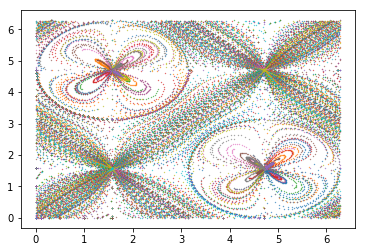

In [3]:
## 2D Flow diagram in the space <H> = 0, classically done
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import tqdm
from numpy import sin, cos, tan, arcsin, pi
import numpy as np
from scipy.integrate import odeint

dθdt = lambda θ1, ϕ1, ϕ2, θ2: tan(θ2)*sin(θ1)*(cos(θ1)**2)*cos(ϕ1) + cos(θ2)*cos(ϕ2)
dϕdt = lambda θ1, ϕ1, ϕ2, θ2: 2*tan(θ1)*cos(θ2)*sin(ϕ2) - 0.5*tan(θ2)*cos(θ1)*sin(ϕ1)*(2*(sin(θ2)**-2) + cos(2*θ1) - 5)

def func_list(angles,t,μ):
    return[dθdt(*angles), -μ + dϕdt(*angles), -μ + dϕdt(*reversed(angles)), dθdt(*reversed(angles))]

def ode_solver(init_angles, t, μ = 0.325):
    
    def func_list(angles,t,μ):
        return[dθdt(*angles), -μ + dϕdt(*angles), -μ + dϕdt(*reversed(angles)), dθdt(*reversed(angles))]
    
    y0 = init_angles
    return np.mod(odeint(func_list, y0, t, args=(μ,)), np.pi * 2)

N = 20
for i in tqdm.tqdm(range(N)):
    for j in range(N):
        θ1s = []
        θ2s = []

        θ1 = (i+1) * 2 * np.pi / N
        θ2 = (j+1) * 2 * np.pi / N
        res = ode_solver([θ1, 0, 0, θ2], t = np.arange(0,100,0.1), μ = 0)
            
        plt.scatter(res[:,0], res[:,-1], s = 0.1)
plt.show()

## 3 Site unit cell

In [22]:
import numpy as np
from numpy import kron
from functools import reduce

from scipy.linalg import expm
from qmps.states import Tensor
from qmps.tools import tensor_to_unitary

import cirq
from qmps.time_evolve_tools import merge, put_env_on_left_site, put_env_on_right_site
from xmps.iMPS import Map
from scipy.optimize import minimize
import json

def multi_tensor(Ops):
    return reduce(kron, Ops)

### Exact hamiltonian simulation for prof of principle ###
P = np.array([[0,0],[0,1]])
X = np.array([[0,1],[1,0]])
n = np.array([[1,0],[0,0]])
I = np.eye(2)

def H(μ):
    H1 = multi_tensor([P,X,P,I,I,I])
    H2 = multi_tensor([I,P,X,P,I,I])
    H3 = multi_tensor([I,I,P,X,P,I])
    H4 = multi_tensor([I,I,I,P,X,P])
    H5 = multi_tensor([I,I,I,I,I,n])
    H6 = multi_tensor([I,I,I,I,n,I])
    H7 = multi_tensor([I,I,I,n,I,I])
    H8 = multi_tensor([I,I,n,I,I,I])
    H9 = multi_tensor([I,n,I,I,I,I])
    H10 = multi_tensor([n,I,I,I,I,I])
    
    return (1/2)*(H1 + H4) + H2 + H3 + (μ/6) * (H5 + H6 + H7 + H8 + H9 + H10)

class ScarsAnsatz(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ], setting ϕ = 0 for all cases
        
    def num_qubits(self):
        return 2
    
    def _decompose_(self, qubits):
        q = qubits
        pi = np.pi
        theta, _ = self.params
        return [
            cirq.ZPowGate(exponent=1/2).on(q[1]),  # would be a ϕ term here but it is set to 0
            cirq.X.on(q[0]),
            cirq.CNOT(q[0], q[1]),
            cirq.X.on(q[0]),
            cirq.CNotPowGate(exponent=2*theta/pi).on(q[1], q[0]),  # global_shift is needed to remove erronous complex numbers
            cirq.S.on(q[0]),
            cirq.ZPowGate(exponent=-theta/pi).on(q[1])
        ]

class ScarGate(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ1, θ2, θ3]

    def num_qubits(self):
        return 4

    def _decompose_(self, qubits):
        q = qubits
        theta1, theta2, theta3 = self.params
        return [
            ScarsAnsatz([theta3, 0]).on(*q[2:4]),
            ScarsAnsatz([theta2, 0]).on(*q[1:3]),
            ScarsAnsatz([theta1, 0]).on(*q[0:2])
        ]
    
    def _circuit_diagram_info_(self, args):
        return ['U']*self.num_qubits()


def scars_time_evolve_cost_function(params, current_params, ham):
    '''
    params are formatted like: [θ1, θ2, θ3
    '''    
    
    A = lambda theta, phi: np.array([[[0, 1j*np.exp(-1j*phi)], 
                                    [0,0]],
                                    [[np.cos(theta), 0],
                                    [np.sin(theta), 0]]])

    theta1, theta2, theta3 = current_params
    theta1_, theta2_, theta3_ = params
        
    A1 = A(theta1, 0)    
    A2 = A(theta2, 0)    
    A3 = A(theta3, 0)    

    A1_= A(theta1_, 0) 
    A2_= A(theta2_, 0) 
    A3_= A(theta3_, 0) 

    
    _, r = Map(merge(merge(A1,A2),A3), merge(merge(A1_,A2_), A3_)).right_fixed_point()
    R = Tensor(put_env_on_left_site(r), 'R')
    L = Tensor(put_env_on_right_site(r.conj().T),'L')
    
    U12 = ScarGate(current_params)
    U12_= ScarGate(params)
    q = cirq.LineQubit.range(10)
    circuit = cirq.Circuit.from_ops([
        cirq.H(q[7]),
        cirq.CNOT(q[7],q[8]),
        U12(*q[4:8]),
        U12(*q[1:5]),
        L(*q[0:2]),
        ham(*q[2:8]),
        R(*q[8:10]),
        cirq.inverse(U12_(*q[1:5])),
        cirq.inverse(U12_(*q[4:8])),
        cirq.CNOT(q[7],q[8]),
        cirq.H(q[7])
    ])
    
    #print(circuit.to_text_diagram(transpose = True))
    sim = cirq.Simulator()
    psi = sim.simulate(circuit).final_state[0]
    return -np.abs(psi)*2


def simulate_scars(initial_params, params):
    dt, timesteps = params
    # μ = 0.325

    W = lambda mu, dt: Tensor(expm(-1j * dt * H(mu)),'H')
    hamiltonian = W(0, dt) # set μ = 0 automatically for the three site experiment
    
    final_params = []
    current_params = initial_params
    for _ in tq.tqdm(range(timesteps)):
        final_params.append(np.mod(current_params, 2*np.pi))
        res = minimize(scars_time_evolve_cost_function, current_params, args = (current_params, hamiltonian), options = {'disp':True}, method = 'Nelder-Mead')
        current_params = res.x
    
    return np.array(final_params)

if __name__ == "__main__":    
    steps = 4000
    dt = 0.05
    init_conds = [0.1, 0, 0.3]
    params = [dt, steps]
    angles = simulate_scars(init_conds, params)

#W = lambda mu, dt: Tensor(expm(1j * dt * H(mu)),'H')
#scars_time_evolve_cost_function([1,2,3],[4,5,6], W(0,0.1))

  0%|          | 1/4000 [00:02<3:05:08,  2.78s/it]

Optimization terminated successfully.
         Current function value: -0.998856
         Iterations: 64
         Function evaluations: 115


  0%|          | 2/4000 [00:04<2:52:52,  2.59s/it]

Optimization terminated successfully.
         Current function value: -0.998840
         Iterations: 53
         Function evaluations: 99


  0%|          | 3/4000 [00:06<2:41:18,  2.42s/it]

Optimization terminated successfully.
         Current function value: -0.998825
         Iterations: 44
         Function evaluations: 86


  0%|          | 4/4000 [00:09<2:44:37,  2.47s/it]

Optimization terminated successfully.
         Current function value: -0.998812
         Iterations: 52
         Function evaluations: 101


  0%|          | 5/4000 [00:12<2:51:12,  2.57s/it]

Optimization terminated successfully.
         Current function value: -0.998800
         Iterations: 66
         Function evaluations: 128


  0%|          | 6/4000 [00:15<3:05:31,  2.79s/it]

Optimization terminated successfully.
         Current function value: -0.998789
         Iterations: 75
         Function evaluations: 137


  0%|          | 7/4000 [00:18<2:58:02,  2.68s/it]

Optimization terminated successfully.
         Current function value: -0.998780
         Iterations: 49
         Function evaluations: 97


  0%|          | 8/4000 [00:19<2:36:22,  2.35s/it]

Optimization terminated successfully.
         Current function value: -0.998773
         Iterations: 34
         Function evaluations: 72


  0%|          | 9/4000 [00:21<2:19:48,  2.10s/it]

Optimization terminated successfully.
         Current function value: -0.998767
         Iterations: 35
         Function evaluations: 69


  0%|          | 10/4000 [00:22<2:14:04,  2.02s/it]

Optimization terminated successfully.
         Current function value: -0.998762
         Iterations: 39
         Function evaluations: 81


  0%|          | 11/4000 [00:24<2:11:21,  1.98s/it]

Optimization terminated successfully.
         Current function value: -0.998759
         Iterations: 41
         Function evaluations: 83


  0%|          | 12/4000 [00:27<2:19:35,  2.10s/it]

Optimization terminated successfully.
         Current function value: -0.998758
         Iterations: 52
         Function evaluations: 99


  0%|          | 13/4000 [00:30<2:38:06,  2.38s/it]

Optimization terminated successfully.
         Current function value: -0.998758
         Iterations: 71
         Function evaluations: 129


  0%|          | 14/4000 [00:32<2:30:29,  2.27s/it]

Optimization terminated successfully.
         Current function value: -0.998759
         Iterations: 43
         Function evaluations: 84


  0%|          | 15/4000 [00:34<2:29:58,  2.26s/it]

Optimization terminated successfully.
         Current function value: -0.998762
         Iterations: 54
         Function evaluations: 103


  0%|          | 16/4000 [00:36<2:19:26,  2.10s/it]

Optimization terminated successfully.
         Current function value: -0.998766
         Iterations: 42
         Function evaluations: 79


  0%|          | 17/4000 [00:37<2:08:31,  1.94s/it]

Optimization terminated successfully.
         Current function value: -0.998771
         Iterations: 36
         Function evaluations: 71


  0%|          | 18/4000 [00:39<2:01:31,  1.83s/it]

Optimization terminated successfully.
         Current function value: -0.998778
         Iterations: 37
         Function evaluations: 72


  0%|          | 19/4000 [00:41<2:00:04,  1.81s/it]

Optimization terminated successfully.
         Current function value: -0.998785
         Iterations: 39
         Function evaluations: 76


  0%|          | 20/4000 [00:42<1:53:07,  1.71s/it]

Optimization terminated successfully.
         Current function value: -0.998793
         Iterations: 34
         Function evaluations: 67


  1%|          | 21/4000 [00:44<1:51:07,  1.68s/it]

Optimization terminated successfully.
         Current function value: -0.998801
         Iterations: 35
         Function evaluations: 73


  1%|          | 22/4000 [00:45<1:47:18,  1.62s/it]

Optimization terminated successfully.
         Current function value: -0.998810
         Iterations: 34
         Function evaluations: 68


  1%|          | 23/4000 [00:47<1:50:33,  1.67s/it]

Optimization terminated successfully.
         Current function value: -0.998819
         Iterations: 40
         Function evaluations: 81


  1%|          | 24/4000 [00:49<1:48:01,  1.63s/it]

Optimization terminated successfully.
         Current function value: -0.998828
         Iterations: 33
         Function evaluations: 71


  1%|          | 25/4000 [00:50<1:46:05,  1.60s/it]

Optimization terminated successfully.
         Current function value: -0.998837
         Iterations: 35
         Function evaluations: 70


  1%|          | 26/4000 [00:52<1:44:13,  1.57s/it]

Optimization terminated successfully.
         Current function value: -0.998845
         Iterations: 33
         Function evaluations: 69


  1%|          | 27/4000 [00:53<1:43:12,  1.56s/it]

Optimization terminated successfully.
         Current function value: -0.998852
         Iterations: 35
         Function evaluations: 70


  1%|          | 28/4000 [00:55<1:42:30,  1.55s/it]

Optimization terminated successfully.
         Current function value: -0.998859
         Iterations: 34
         Function evaluations: 70


  1%|          | 29/4000 [00:56<1:47:22,  1.62s/it]

Optimization terminated successfully.
         Current function value: -0.998864
         Iterations: 36
         Function evaluations: 73


  1%|          | 30/4000 [00:59<1:58:33,  1.79s/it]

Optimization terminated successfully.
         Current function value: -0.998868
         Iterations: 39
         Function evaluations: 81


  1%|          | 31/4000 [01:01<2:02:05,  1.85s/it]

Optimization terminated successfully.
         Current function value: -0.998869
         Iterations: 42
         Function evaluations: 86


  1%|          | 32/4000 [01:02<1:54:49,  1.74s/it]

Optimization terminated successfully.
         Current function value: -0.998869
         Iterations: 31
         Function evaluations: 66


  1%|          | 33/4000 [01:04<1:56:50,  1.77s/it]

Optimization terminated successfully.
         Current function value: -0.998868
         Iterations: 33
         Function evaluations: 70


  1%|          | 34/4000 [01:05<1:52:28,  1.70s/it]

Optimization terminated successfully.
         Current function value: -0.998864
         Iterations: 31
         Function evaluations: 69


  1%|          | 35/4000 [01:07<1:53:32,  1.72s/it]

Optimization terminated successfully.
         Current function value: -0.998858
         Iterations: 31
         Function evaluations: 68


  1%|          | 36/4000 [01:09<1:50:25,  1.67s/it]

Optimization terminated successfully.
         Current function value: -0.998850
         Iterations: 33
         Function evaluations: 72


  1%|          | 37/4000 [01:10<1:45:21,  1.60s/it]

Optimization terminated successfully.
         Current function value: -0.998839
         Iterations: 31
         Function evaluations: 65


  1%|          | 38/4000 [01:12<1:43:47,  1.57s/it]

Optimization terminated successfully.
         Current function value: -0.998828
         Iterations: 32
         Function evaluations: 70


  1%|          | 39/4000 [01:13<1:44:59,  1.59s/it]

Optimization terminated successfully.
         Current function value: -0.998814
         Iterations: 32
         Function evaluations: 71


  1%|          | 40/4000 [01:15<1:47:29,  1.63s/it]

Optimization terminated successfully.
         Current function value: -0.998800
         Iterations: 31
         Function evaluations: 69


  1%|          | 41/4000 [01:17<1:45:15,  1.60s/it]

Optimization terminated successfully.
         Current function value: -0.998784
         Iterations: 28
         Function evaluations: 63


  1%|          | 42/4000 [01:19<1:51:58,  1.70s/it]

Optimization terminated successfully.
         Current function value: -0.998768
         Iterations: 35
         Function evaluations: 75


  1%|          | 43/4000 [01:20<1:53:55,  1.73s/it]

Optimization terminated successfully.
         Current function value: -0.998751
         Iterations: 32
         Function evaluations: 70


  1%|          | 44/4000 [01:22<1:56:05,  1.76s/it]

Optimization terminated successfully.
         Current function value: -0.998735
         Iterations: 36
         Function evaluations: 75


  1%|          | 45/4000 [01:24<1:59:35,  1.81s/it]

Optimization terminated successfully.
         Current function value: -0.998719
         Iterations: 35
         Function evaluations: 79


  1%|          | 46/4000 [01:26<1:55:35,  1.75s/it]

Optimization terminated successfully.
         Current function value: -0.998703
         Iterations: 30
         Function evaluations: 70


  1%|          | 47/4000 [01:27<1:52:09,  1.70s/it]

Optimization terminated successfully.
         Current function value: -0.998689
         Iterations: 32
         Function evaluations: 68


  1%|          | 48/4000 [01:29<1:48:13,  1.64s/it]

Optimization terminated successfully.
         Current function value: -0.998676
         Iterations: 32
         Function evaluations: 67


  1%|          | 49/4000 [01:31<1:51:07,  1.69s/it]

Optimization terminated successfully.
         Current function value: -0.998664
         Iterations: 33
         Function evaluations: 73


  1%|▏         | 50/4000 [01:32<1:51:41,  1.70s/it]

Optimization terminated successfully.
         Current function value: -0.998654
         Iterations: 28
         Function evaluations: 64


  1%|▏         | 51/4000 [01:34<1:46:44,  1.62s/it]

Optimization terminated successfully.
         Current function value: -0.998646
         Iterations: 30
         Function evaluations: 65


  1%|▏         | 52/4000 [01:35<1:44:53,  1.59s/it]

Optimization terminated successfully.
         Current function value: -0.998639
         Iterations: 30
         Function evaluations: 66


  1%|▏         | 53/4000 [01:37<1:51:58,  1.70s/it]

Optimization terminated successfully.
         Current function value: -0.998634
         Iterations: 37
         Function evaluations: 81


KeyboardInterrupt: 

In [6]:
a = ode_solver([0.1,0,0.3], t_eval = [i*0.05for i in range(200)])

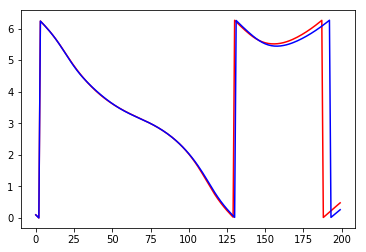

In [7]:
plt.plot(angles[:,0], 'r')
plt.plot(np.mod(a.y[0], np.pi *2),'b')


In [40]:
len(a.y[0])

200

In [1]:
from numpy import sin, cos
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import tqdm as tq
import numpy as np
from scipy.integrate import odeint, solve_ivp
from joblib import Parallel, delayed

sin2 = lambda x: sin(x)**2
cos2 = lambda x: cos(x)**2
sin3 = lambda x: sin(x)**3
cos3 = lambda x: cos(x)**3

def θ1dot(θ1, θ2, θ3):
    m1 = lambda θ1, θ2, θ3: 4 * (3 + cos(2*θ2) - 2*cos(2*θ3)*sin2(θ2))
    return (4*sin2(θ2)*cos(3*θ3) + 
            2*sin(θ1)*sin(2*θ2)*(-2*cos2(θ1)*cos(2*θ3) + cos(2*θ1) -3 ) - 
            2*cos(θ3)*(3*cos(2*θ2) + 5) ) / m1(θ1, θ2, θ3)

def θ2dot(θ1, θ2, θ3):
    m2 = lambda θ1, θ2, θ3: 64 * (cos2(θ3) + sin2(θ1)*sin2(θ3))
    return (-4*sin(2*θ3)*((cos(2*θ1)+7)*sin(θ2) - 2*sin2(θ1)*sin(3*θ1)) - 
            8*cos(θ1)*(4*cos2(θ1)*cos(2*θ3)+5) + 
            8*cos(3*θ1)) / m2(θ1, θ2, θ3)

def θ3dot(θ1, θ2, θ3):
    m3 = lambda θ1, θ2, θ3: -16*(1 - cos2(θ2)*sin2(θ1))
    return (-2*sin2(θ2)*sin(2*θ1)*sin(3*θ3) + 
            sin(2*θ1)*sin(θ3)*(cos(2*θ2)+7)+
            8*cos(2*θ1)*cos3(θ2) +
            10*cos(θ2) - 
            2*cos(3*θ2)) / m3(θ1, θ2, θ3)



def ode_solver(init_angles, t_eval = None):
    
    def func_list(t, angles):
        return[θ1dot(*angles), θ2dot(*angles), θ3dot(*angles)]
    
    def event(t, y):
        return np.mod(y[1] + np.pi, 2*np.pi) - np.pi
    
    event.direction = 1
    
    y0 = init_angles
    return solve_ivp(func_list,(0,500), y0, events = event, t_eval= np.arange(0,500,0.001))


θ1_line = np.arange(0.01,2*np.pi, 0.3)
θ3_line = np.arange(0.01,2*np.pi, 0.3)
x,y = np.meshgrid(θ1_line, θ3_line)
list_of_values = []
for i in range(len(x)):
    for j in range(len(y)):
        list_of_values.append([x[i,j], 0, y[i,j]])

        
t = np.arange(0,100,0.38)
list_of_angles = Parallel(n_jobs=-1)(delayed(ode_solver)(i) for i in tq.tqdm(list_of_values))


 62%|██████▏   | 272/441 [00:30<00:11, 15.21it/s]

KeyboardInterrupt: 

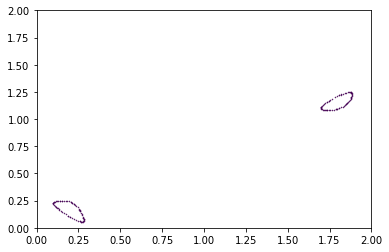

In [60]:
angles = ode_solver(list_of_values[83])
#angles = list_of_angles[83:84]
plt.figure()
cm = plt.cm.viridis
plt.gca().set_prop_cycle(plt.cycler('color', cm(np.linspace(0, 1, len(angles)))))
for i, angles in enumerate([angles]):
    events = np.mod(angles.y_events[0], 2*np.pi)
    try:
        plt.ylim(0, 2)
        plt.xlim(0,2)
        plt.plot(events[:,2]/np.pi, events[:,0]/np.pi, '.', ms=1)
    except:
        pass
plt.show()

##### Check the new quantum results to see how to best calculate a poincare map

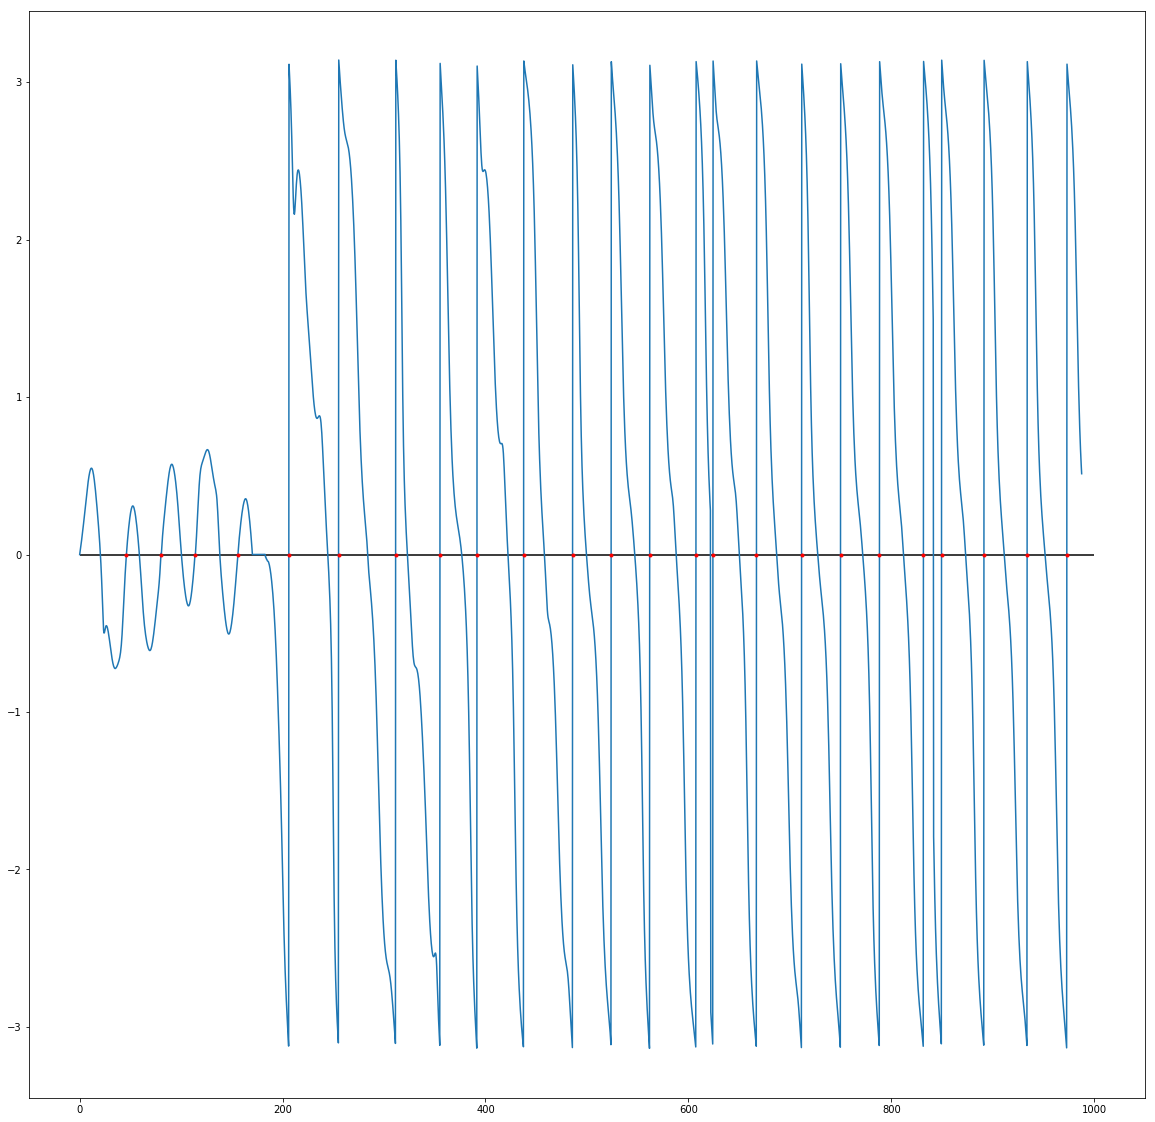

In [136]:
import yaml
with open('./qmps/three_site_output/output/long_evo_results_3_site_100.yml') as f:
    data = yaml.load(f, Loader=yaml.Loader)

results = data['data']

###
#  Put the results in a form so that a change of sign can be used to indicate crossing the θ2=0 plane
###

mod_results = np.mod(results + np.pi, 2*np.pi) - np.pi
print(mod_results)

sign_results = np.sign(mod_results)
print(sign_results)

###
#  In this form a plane crossing will appear as either -2 (+ve -> -ve) or +2 (-ve -> +ve)
###

diff_sign = np.diff(sign_results, axis=0)
print(diff_sign)

###
#  How many crossings do we get
#  This is quite low, looks like it is a factor of 4 lower than the classical simulation with
#  the same parameters. Might have to go roughly 4x longer in the simulation.
###

print(sum(diff_sign[:,1] == 2))
print(sum(diff_sign[:,1] == -2))

###
#  We are going to use interpolation so we need a time paramater. We used 2600 steps with dt = 0.38 
#  in the simulation so this will be used to make the time parameter
###

t = [i*0.38 for i in range(2600)]

###
#  Look where the sign changes in the positive direciton
###

sign_change_location = np.argwhere(diff_sign[:,1] == 2)
print(sign_change_location)

###
#  Use 1D interpolation to estimate the θ2 function locally around the sign change location.
#  Do the same to estimate the functions of θ1 and θ3 around the sign change.
#  Use a root finding algorithm to then get the estimated time at which the sign changed.
#  This is then fed into the estimates for θ1 and θ3 to find their values at the time of crossing.
###
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
f1 = interp1d(t[119:124], mod_results[119:124,0], kind='linear')
f2 = interp1d(t[119:124], mod_results[119:124,1], kind='linear')
f3 = interp1d(t[119:124], mod_results[119:124,2], kind='linear')

sol = root_scalar(f2, bracket=(t[121], t[122]))

print(sol)


###
#  Check the effectiveness of the interpolation + root finding algos to find the points of crossing.
#  This appears identify the zeros very well!
###

%matplotlib inline
plt.figure(figsize = (20,20))
plt.plot(t, mod_results[:,1])
plt.hlines(y=0, xmin=0, xmax=1000)
for x in sign_change_location:
    x=x[0]
    f2 = interp1d(t[x-5:x+5], mod_results[x-5:x+5,1], kind='cubic')
    sol = root_scalar(f2, bracket=(t[x], t[x+1]))
    plt.plot(sol.root, f2(sol.root), '.', c='r')

plt.show()

###
#  What difference the interpolation method makes, not a huge difference 
#  Linear is much faster than cubic so we will continue with this
###

x=121
f2c = interp1d(t[x-5:x+5], mod_results[x-5:x+5,1], kind='cubic')
f2l = interp1d(t[x-5:x+5], mod_results[x-5:x+5,1], kind='linear')
f2q = interp1d(t[x-5:x+5], mod_results[x-5:x+5,1], kind='quadratic')
solc = root_scalar(f2c, bracket=(t[x], t[x+1]))
soll = root_scalar(f2l, bracket=(t[x], t[x+1]))
solq = root_scalar(f2q, bracket=(t[x], t[x+1]))

print(solc.root, soll.root, solq.root)
print('\n ---------------------- \n')
print(f1(solc.root), f1(solq.root), f1(soll.root))
print('\n ---------------------- \n') 
print(f3(solc.root), f3(solq.root), f3(soll.root))


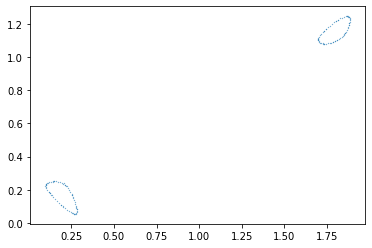

In [64]:
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

def find_crossing_points(θ2s):
    sign_of_angle = np.sign(θ2s)
    sign_diff = np.diff(sign_of_angle)
    sign_change_location = np.argwhere(sign_diff == 2)
    return sign_change_location

def centre_plane(θ2s):
    return np.mod(θ2s + np.pi, 2*np.pi) - np.pi

def find_zero(x,t,f2):
    # x is the crossing location
    sol = root_scalar(f2, bracket=(t[x], t[x+1]))
    return sol.root

def interpolate_functions(x, t, results):
    mod_results = centre_plane(results[:,1])
    if x > 5:
        f1 = interp1d(t[x-5:x+5], results[x-5:x+5,0], kind='cubic')
        f2 = interp1d(t[x-5:x+5], mod_results[x-5:x+5], kind='cubic')
        f3 = interp1d(t[x-5:x+5], results[x-5:x+5,2], kind='cubic')
    else:
        f1 = interp1d(t[x-1:x+2], results[x-1:x+2,0], kind='linear')
        f2 = interp1d(t[x-1:x+2], mod_results[x-1:x+2], kind='linear')
        f3 = interp1d(t[x-1:x+2], results[x-1:x+2,2], kind='linear')

    return f1, f2, f3

def get_map(results,t):
    mod_θ2 = centre_plane(results[:,1])
    x_points = find_crossing_points(mod_θ2)
    θ1s = []
    θ3s = []
    for x in x_points:
        f1,f2,f3 = interpolate_functions(x[0],t,results)
        t0 = find_zero(x[0],t,f2)
        θ1_0 = f1(t0)
        θ3_0 = f3(t0)

        θ1s.append(θ1_0)
        θ3s.append(θ3_0)

    plt.plot(np.mod(np.array(θ3s),2*np.pi)/np.pi, np.mod(np.array(θ1s),np.pi * 2)/np.pi, '.', ms = 0.5)

get_map(.y.T, np.arange(0,500,0.001))
# import yaml
# for j in range(2):
#     if j == 0:
#         t = [i*0.38 for i in range(2600)]
#         for i in range(1,442): 
#             try:
#                 with open(f'./qmps/three_site_output/output/long_evo_results_3_site_{i}.yml') as f:
#                     data = yaml.load(f, Loader=yaml.Loader)
#             except:
#                 continue
            
#             get_map(data, t)
#     else:
#         t = [i*0.1 for i in range(2000)]
#         for i in range(1,901): 
#             try:
#                 with open(f'./qmps/three_site_output/output/results_3_site_{i}.yml') as f:
#                     data = yaml.load(f, Loader=yaml.Loader)
#             except:
#                 continue
            
#             get_map(data, t)
                


In [32]:
list_of_angles[0].t

array([0.00000000e+00, 1.27521564e-03, 1.40273720e-02, ...,
       9.98747780e+02, 9.99991029e+02, 1.00000000e+03])

<IPython.core.display.Javascript object>


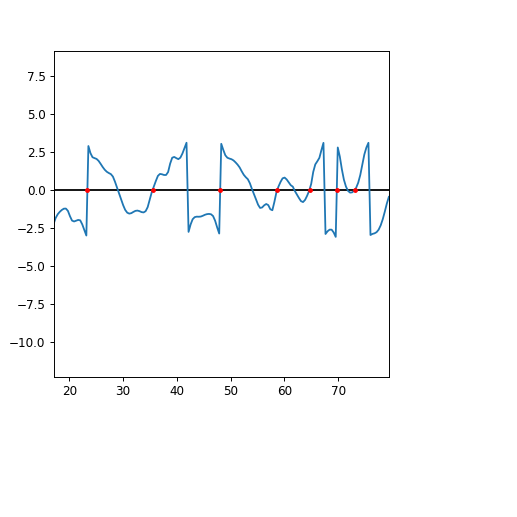

In [15]:
%matplotlib notebook
%matplotlib notebook
###
#  check the zeros are found correctly [X]
###
results = list_of_angles[0].y.T
t = list_of_angles[0].t
mod_θ2 = centre_plane(results[:,1])
x_points = find_crossing_points(mod_θ2)
plt.figure(figsize = (5,5))
plt.plot(t, np.mod(results[:,1] + np.pi, np.pi *2) - np.pi)
plt.hlines(y = 0, xmin = 0, xmax = 1000)
for x in x_points:
    f1,f2,f3 = interpolate_functions(x[0],t, results)
    t0 = find_zero(x[0], t, f2)
    plt.plot(t0, f2(t0), '.', c = 'r')


In [1]:
from numpy import sin, cos
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import tqdm as tq
import numpy as np
from scipy.integrate import odeint, solve_ivp
from joblib import Parallel, delayed

sin2 = lambda x: sin(x)**2
cos2 = lambda x: cos(x)**2
sin3 = lambda x: sin(x)**3
cos3 = lambda x: cos(x)**3

def θ1dot(θ1, θ2, θ3):
    m1 = lambda θ1, θ2, θ3: 4 * (3 + cos(2*θ2) - 2*cos(2*θ3)*sin2(θ2))
    return (4*sin2(θ2)*cos(3*θ3) + 
            2*sin(θ1)*sin(2*θ2)*(-2*cos2(θ1)*cos(2*θ3) + cos(2*θ1) -3 ) - 
            2*cos(θ3)*(3*cos(2*θ2) + 5) ) / m1(θ1, θ2, θ3)

def θ2dot(θ1, θ2, θ3):
    m2 = lambda θ1, θ2, θ3: 64 * (cos2(θ3) + sin2(θ1)*sin2(θ3))
    return (-4*sin(2*θ3)*((cos(2*θ1)+7)*sin(θ2) - 2*sin2(θ1)*sin(3*θ1)) - 
            8*cos(θ1)*(4*cos2(θ1)*cos(2*θ3)+5) + 
            8*cos(3*θ1)) / m2(θ1, θ2, θ3)

def θ3dot(θ1, θ2, θ3):
    m3 = lambda θ1, θ2, θ3: -16*(1 - cos2(θ2)*sin2(θ1))
    return (-2*sin2(θ2)*sin(2*θ1)*sin(3*θ3) + 
            sin(2*θ1)*sin(θ3)*(cos(2*θ2)+7)+
            8*cos(2*θ1)*cos3(θ2) +
            10*cos(θ2) - 
            2*cos(3*θ2)) / m3(θ1, θ2, θ3)



def ode_solver(init_angles, t_eval = None):
    
    def func_list(t, angles):
        return[θ1dot(*angles), θ2dot(*angles), θ3dot(*angles)]
    
    def event(t, y):
        return np.mod(y[1] + np.pi, 2*np.pi) - np.pi
    
    event.direction = 1
    
    y0 = init_angles
    return solve_ivp(func_list,(0,1000), y0, events = event, method = "Radau", t_eval= t_eval)


θ1_line = np.arange(0.01, 2*np.pi, 0.3)
θ3_line = np.arange(0.01, 2*np.pi, 0.3)
x,y = np.meshgrid(θ3_line, θ1_line)
list_of_values = []
for i in range(len(x)):
    for j in range(len(y)):
        list_of_values.append([x[i,j], 0, y[i,j]])

        
t = [i*0.025 for i in range(400)]
list_of_angles = Parallel(n_jobs=-1)(delayed(ode_solver)(i, None) for i in tq.tqdm(list_of_values))


100%|██████████| 441/441 [04:21<00:00,  1.69it/s]


<IPython.core.display.Javascript object>


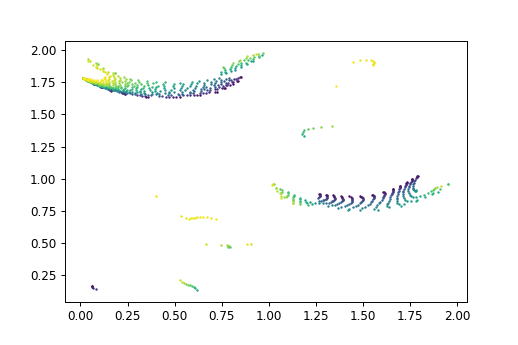

In [27]:
%matplotlib notebook
%matplotlib notebook

cm = plt.cm.viridis
plt.gca().set_prop_cycle(plt.cycler('color', cm(np.linspace(0, 1, len(list_of_angles)))))
for solution in list_of_angles:
    t = solution.t
    results = solution.y.T
    mod_θ2 = centre_plane(results[:,1])
    x_points = find_crossing_points(mod_θ2)
    θ1s = []
    θ3s = []
    for x in x_points:
        f1,f2,f3 = interpolate_functions(x[0],t,results)
        t0 = find_zero(x[0],t,f2)
        θ1_0 = f1(t0)
        θ3_0 = f3(t0)

        θ1s.append(θ1_0)
        θ3s.append(θ3_0)

    plt.plot(np.mod(np.array(θ3s),np.pi*2)/np.pi, np.mod(np.array(θ1s),np.pi*2)/np.pi, '.', ms = 2)


<IPython.core.display.Javascript object>


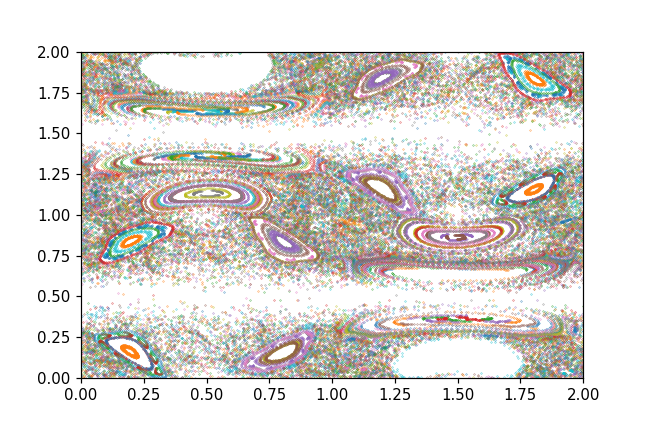

In [3]:
%matplotlib notebook
%matplotlib notebook
plt.figure()
for i, angles in enumerate(list_of_angles):
    events = np.mod(angles.y_events[0], 2*np.pi)
    try:
        plt.ylim(0, 2)
        plt.xlim(0,2)
        plt.plot(events[:,2]/np.pi, events[:,0]/np.pi, '.', ms=0.5)
    except:
        pass
plt.show()

<IPython.core.display.Javascript object>


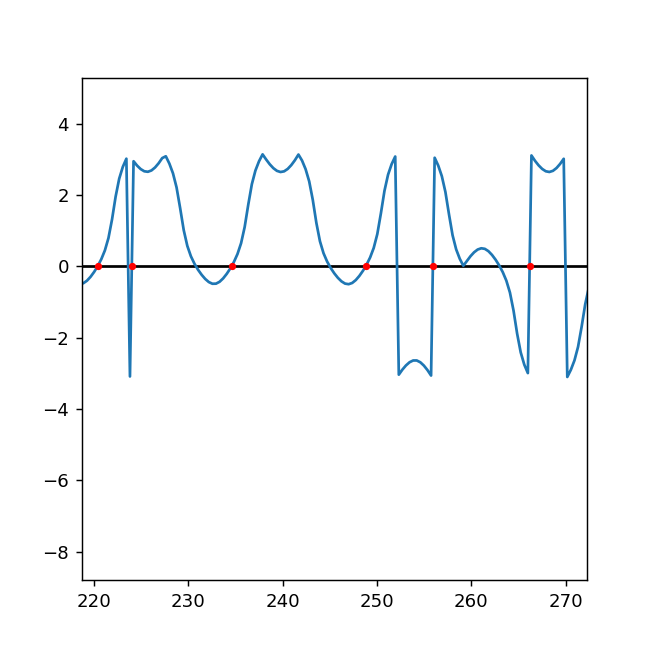

107


In [7]:
%matplotlib notebook
%matplotlib notebook

import yaml
with open('./qmps/three_site_output/output/very_long_evo_results_3_site_913.yml') as f:
    result = yaml.load(f, Loader = yaml.Loader)
    
###
#  check the zeros are found correctly [X]
###
results = result['data']
t = [i*0.38 for i in range(2000)]
mod_θ2 = centre_plane(results[:,1])
x_points = find_crossing_points(mod_θ2)
plt.figure(figsize = (5,5))
plt.plot(t, np.mod(results[:,1] + np.pi, np.pi *2) - np.pi)
plt.hlines(y = 0, xmin = 0, xmax = 800)
for x in x_points:
    f1,f2,f3 = interpolate_functions(x[0],t, results)
    t0 = find_zero(x[0], t, f2)
    plt.plot(t0, f2(t0), '.', c = 'r')

print(len(x_points))



 24%|██▍       | 409/1700 [01:06<03:20,  6.44it/s]


 48%|████▊     | 811/1700 [02:12<01:39,  8.95it/s]


 69%|██████▉   | 1180/1700 [03:17<01:41,  5.14it/s]


 89%|████████▊ | 1505/1700 [04:21<00:44,  4.41it/s]


100%|██████████| 1700/1700 [04:50<00:00,  5.85it/s]


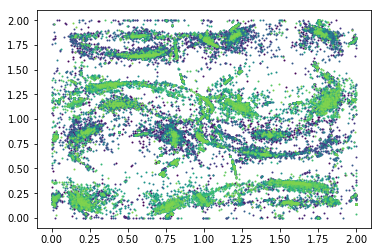

In [69]:
%matplotlib notebook
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import yaml

t = [i*0.38 for i in range(2000)]
cm = plt.cm.viridis
plt.gca().set_prop_cycle(plt.cycler('color', cm(np.linspace(0, 1, len(range(1,1701))))))

for i in tq.tqdm(range(1,1701)):
    try:
        with open(f'~/qmps/three_site_output/output/very_long_evo_results_3_site_{i}.yml') as f:
            result = yaml.load(f, Loader = yaml.Loader)
    except: 
        continue

    results = result['data']
    mod_θ2 = centre_plane(results[:,1])
    x_points = find_crossing_points(mod_θ2)
    θ1s = []
    θ3s = []
    for x in x_points:
        f1,f2,f3 = interpolate_functions(x[0],t,results)
        t0 = find_zero(x[0],t,f2)
        θ1_0 = f1(t0)
        θ3_0 = f3(t0)

        θ1s.append(θ1_0)
        θ3s.append(θ3_0)

    plt.plot(np.mod(np.array(θ3s),np.pi*2)/np.pi, np.mod(np.array(θ1s),np.pi*2)/np.pi, '.', ms = 2)

plt.show()


<IPython.core.display.Javascript object>


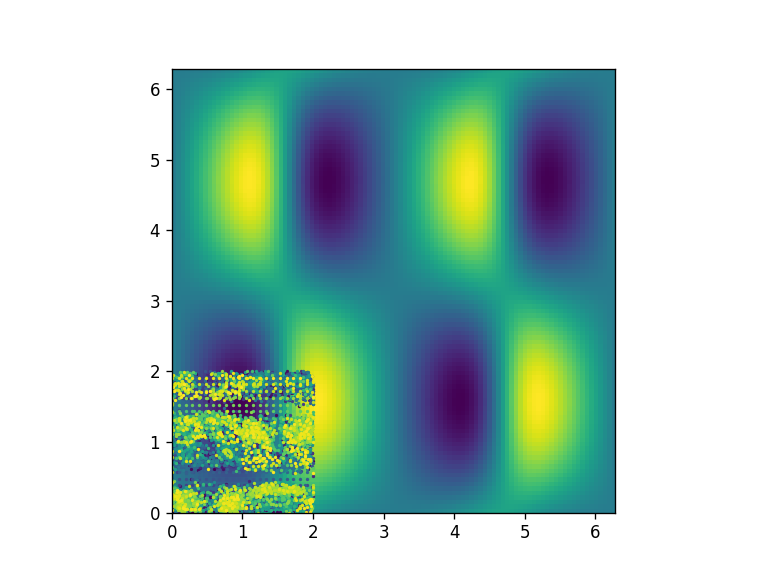

100%|██████████| 440/440 [01:06<00:00,  6.63it/s]


In [3]:
%matplotlib notebook
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import yaml
import tqdm as tq

t = [i*0.05 for i in range(4000)]
cm = plt.cm.viridis
plt.gca().set_prop_cycle(plt.cycler('color', cm(np.linspace(0, 1, len(range(1,441))))))

for i in tq.tqdm(range(1,441)):
    try:
        with open(f'./three_site_output_short_step/output/short_step_long_time_{i}.yml') as f:
            result = yaml.load(f, Loader = yaml.Loader)
    except: 
        continue

    results = result['data']
    assert len(results) > 0
    mod_θ2 = centre_plane(results[:,1])
    x_points = find_crossing_points(mod_θ2)
    assert len(x_points) > 0
    θ1s = [results[0,0]]
    θ3s = [results[0,2]]

    for x in x_points:
        f1,f2,f3 = interpolate_functions(x[0],t,results)
        t0 = find_zero(x[0],t,f2)
        assert np.allclose(0, f2(t0), )
        θ1_0 = f1(t0)
        θ3_0 = f3(t0)

        θ1s.append(θ1_0)
        θ3s.append(θ3_0)

    plt.plot(np.mod(np.array(θ3s),np.pi*2)/np.pi, np.mod(np.array(θ1s),np.pi*2)/np.pi, '.', ms = 2)

plt.show()


In [8]:
import yaml
counter = 0
for i in range(1,441):
    try:
        with open(f'./three_site_output_short_step/output/short_step_long_time_{i}.yml') as f:
            result = yaml.load(f, Loader = yaml.Loader)
        
    except:
        continue
    
    assert len(result['data']) > 0
    
    counter += 1

print(counter)


440


In [6]:
with open(f'./three_site_output_short_step/output/short_step_long_time_{1}.yml') as f:
    result = yaml.load(f, Loader = yaml.Loader)


NameError: name 'yaml' is not defined